**Источник данных:** [https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption?resource=download](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption?resource=download)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
df = pd.read_csv('C:/Users/Ivan/Desktop/ML-3/powerconsumption.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

print("Размерность данных:", df.shape)
df.head()

Размерность данных: (52416, 9)


,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


# Создание целевого класса

Поскольку исходный датасет не содержит категориальных целевых переменных, создадим искусственный целевой класс на основе уровней потребления.

In [8]:
df['Total_Consumption'] = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].sum(axis=1)

consumption_quantiles = df['Total_Consumption'].quantile([0.25, 0.5, 0.75])
print("Квантили суммарного потребления:")
print(consumption_quantiles)

def create_consumption_class(consumption):
    if consumption <= consumption_quantiles[0.25]:
        return 'Low'
    elif consumption <= consumption_quantiles[0.5]:
        return 'Medium-Low'
    elif consumption <= consumption_quantiles[0.75]:
        return 'Medium-High'
    else:
        return 'High'

df['Consumption_Class'] = df['Total_Consumption'].apply(create_consumption_class)

Квантили суммарного потребления:
0.25    56499.07464
0.50    69788.79094
0.75    83749.17231
Name: Total_Consumption, dtype: float64


# Анализ сбалансированности классов

Распределение классов:
Consumption_Class
Medium-High    13104
Medium-Low     13104
Low            13104
High           13104
Name: count, dtype: int64


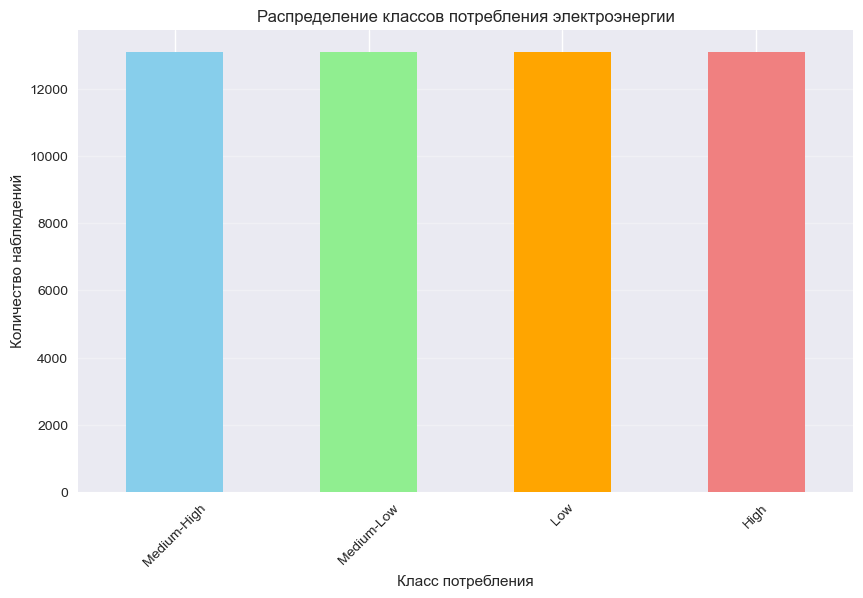

In [9]:
class_distribution = df['Consumption_Class'].value_counts()
print("Распределение классов:")
print(class_distribution)

plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
plt.title('Распределение классов потребления электроэнергии')
plt.xlabel('Класс потребления')
plt.ylabel('Количество наблюдений')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

**Проверка сбалансированности**

In [10]:
balance_ratio = class_distribution.min() / class_distribution.max()
print(f"Коэффициент сбалансированности: {balance_ratio:.3f}")

Коэффициент сбалансированности: 1.000


**Пороговые значения:**

Low: ≤ 56,499 кВт

Medium-Low: 56,499 - 69,789 кВт

Medium-High: 69,789 - 83,749 кВт

High: > 83,749 кВт

# Подготовка признаков

**Создание временных признаков**

In [11]:
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['IsWeekend'] = (df['Datetime'].dt.dayofweek >= 5).astype(int)

feature_columns = ['Temperature', 'Humidity', 'WindSpeed', 
                  'GeneralDiffuseFlows', 'DiffuseFlows', 
                  'Hour', 'DayOfWeek', 'IsWeekend']

print("Используемые признаки:", feature_columns)

Используемые признаки: ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour', 'DayOfWeek', 'IsWeekend']


# Кодирование целевой переменной и разделение данных

In [12]:
le = LabelEncoder()
df['Consumption_Class_Encoded'] = le.fit_transform(df['Consumption_Class'])

print("Соответствие классов:")
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for class_name, class_code in class_mapping.items():
    print(f"  {class_name}: {class_code}")


Соответствие классов:
  High: 0
  Low: 1
  Medium-High: 2
  Medium-Low: 3


**Подготовка данных для обучения**

In [13]:
X = df[feature_columns]
y = df['Consumption_Class_Encoded']

print(f"\nРазмерность признаков: {X.shape}")
print(f"Количество классов: {len(np.unique(y))}")


Размерность признаков: (52416, 8)
Количество классов: 4


**Разделение на обучающую и тестовую выборки**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

Обучающая выборка: (36691, 8)
Тестовая выборка: (15725, 8)


**Масштабирование признаков для kNN**

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение моделей

**kNN**

In [17]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

Accuracy: 0.8685

Classification Report:
              precision    recall  f1-score   support

        High       0.91      0.93      0.92      3931
         Low       0.92      0.94      0.93      3931
 Medium-High       0.81      0.82      0.82      3932
  Medium-Low       0.83      0.79      0.81      3931

    accuracy                           0.87     15725
   macro avg       0.87      0.87      0.87     15725
weighted avg       0.87      0.87      0.87     15725



**Дерево решений**

In [18]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

Accuracy: 0.7521

Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.81      0.85      3931
         Low       0.84      0.93      0.88      3931
 Medium-High       0.61      0.78      0.68      3932
  Medium-Low       0.70      0.49      0.57      3931

    accuracy                           0.75     15725
   macro avg       0.76      0.75      0.75     15725
weighted avg       0.76      0.75      0.75     15725



# Сравнение метрик качества

**Матрицы ошибок**

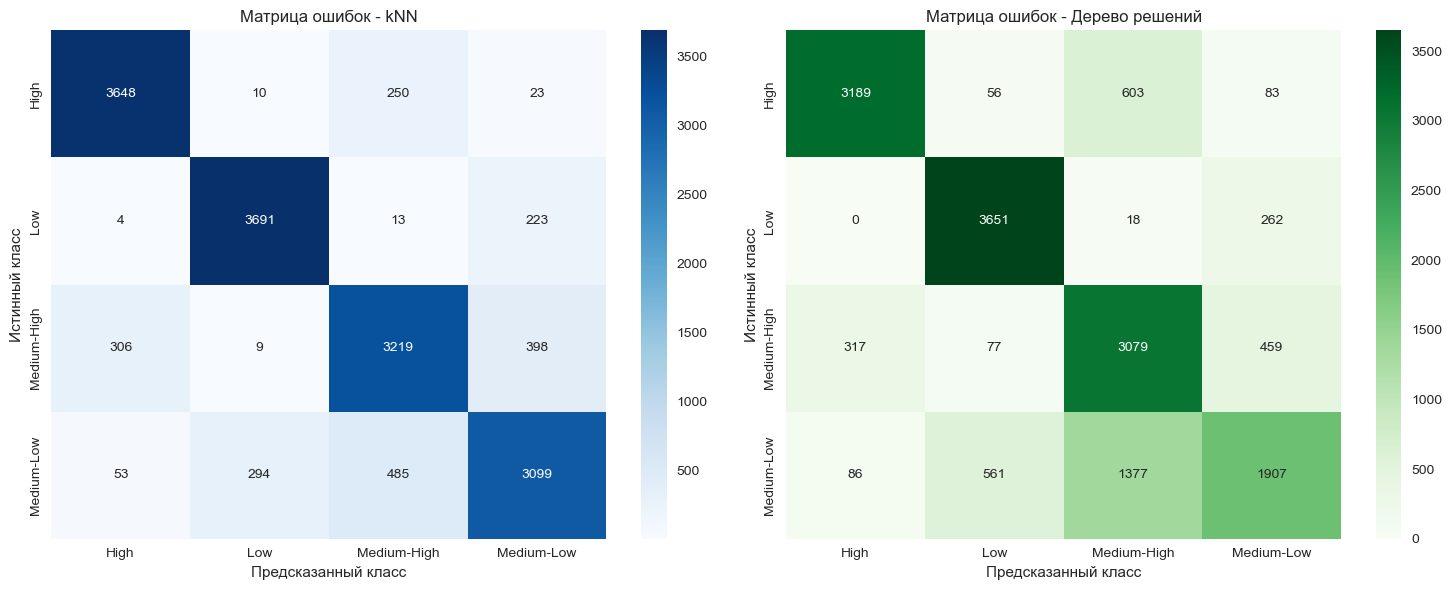

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=le.classes_, yticklabels=le.classes_)
ax1.set_title('Матрица ошибок - kNN')
ax1.set_xlabel('Предсказанный класс')
ax1.set_ylabel('Истинный класс')

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=le.classes_, yticklabels=le.classes_)
ax2.set_title('Матрица ошибок - Дерево решений')
ax2.set_xlabel('Предсказанный класс')
ax2.set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

**ROC-кривые**

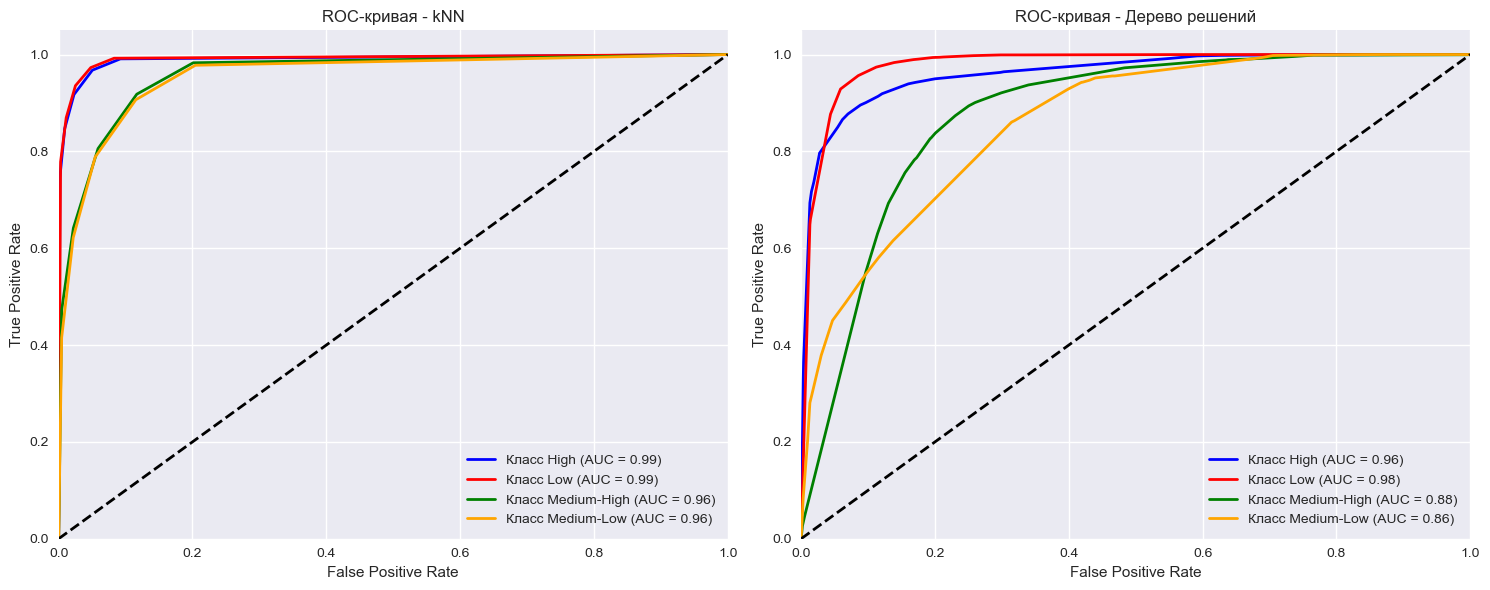

Макро-усредненный AUC kNN: 0.9736
Макро-усредненный AUC Дерево решений: 0.9196


In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
n_classes = len(le.classes_)

for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test == i, y_prob_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr_knn[i], tpr_knn[i], color=color, lw=2,
             label='Класс {0} (AUC = {1:0.2f})'.format(le.classes_[i], roc_auc_knn[i]))

ax1.plot([0, 1], [0, 1], 'k--', lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-кривая - kNN')
ax1.legend(loc="lower right")

fpr_dt = dict()
tpr_dt = dict()
roc_auc_dt = dict()

for i in range(n_classes):
    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test == i, y_prob_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr_dt[i], tpr_dt[i], color=color, lw=2,
             label='Класс {0} (AUC = {1:0.2f})'.format(le.classes_[i], roc_auc_dt[i]))

ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-кривая - Дерево решений')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

macro_auc_knn = np.mean(list(roc_auc_knn.values()))
macro_auc_dt = np.mean(list(roc_auc_dt.values()))

print(f"Макро-усредненный AUC kNN: {macro_auc_knn:.4f}")
print(f"Макро-усредненный AUC Дерево решений: {macro_auc_dt:.4f}")

**Сравнительная таблица метрик**

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred, y_prob, algorithm_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    auc_scores = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
        auc_scores.append(auc(fpr, tpr))
    mean_auc = np.mean(auc_scores)
    
    return {
        'Algorithm': algorithm_name,
        'Accuracy': accuracy,
        'Precision (macro)': precision,
        'Recall (macro)': recall,
        'F1-Score (macro)': f1,
        'AUC (macro)': mean_auc
    }

metrics_knn = calculate_metrics(y_test, y_pred_knn, y_prob_knn, 'kNN')
metrics_dt = calculate_metrics(y_test, y_pred_dt, y_prob_dt, 'Decision Tree')

metrics_comparison = pd.DataFrame([metrics_knn, metrics_dt])
print(metrics_comparison.round(4))

       Algorithm  Accuracy  Precision (macro)  Recall (macro)  \
0            kNN    0.8685             0.8677          0.8685   
1  Decision Tree    0.7521             0.7595          0.7520   

   F1-Score (macro)  AUC (macro)  
0            0.8679       0.9736  
1            0.7470       0.9196  


# Дополнительный анализ

**Кросс-валидация**

In [23]:
X_scaled = scaler.fit_transform(X)
knn_scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')
print(f"kNN Accuracy: {knn_scores.mean():.3f} ± {knn_scores.std():.3f}")

dt_scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
print(f"Decision Tree Accuracy: {dt_scores.mean():.3f} ± {dt_scores.std():.3f}")

kNN Accuracy: 0.572 ± 0.058
Decision Tree Accuracy: 0.684 ± 0.095


**Важность признаков**

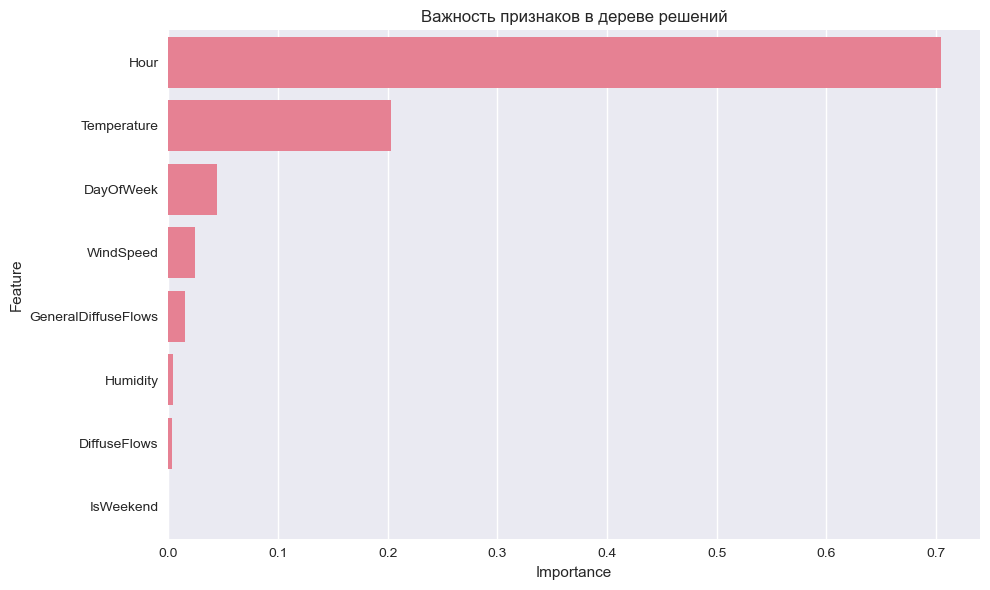

Топ-5 наиболее важных признаков:
               Feature  Importance
5                 Hour      0.7049
0          Temperature      0.2032
6            DayOfWeek      0.0443
2            WindSpeed      0.0245
3  GeneralDiffuseFlows      0.0153


In [24]:
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Важность признаков в дереве решений')
plt.tight_layout()
plt.show()

print("Топ-5 наиболее важных признаков:")
print(feature_importance.head().round(4))

**Визуализация дерева решений**

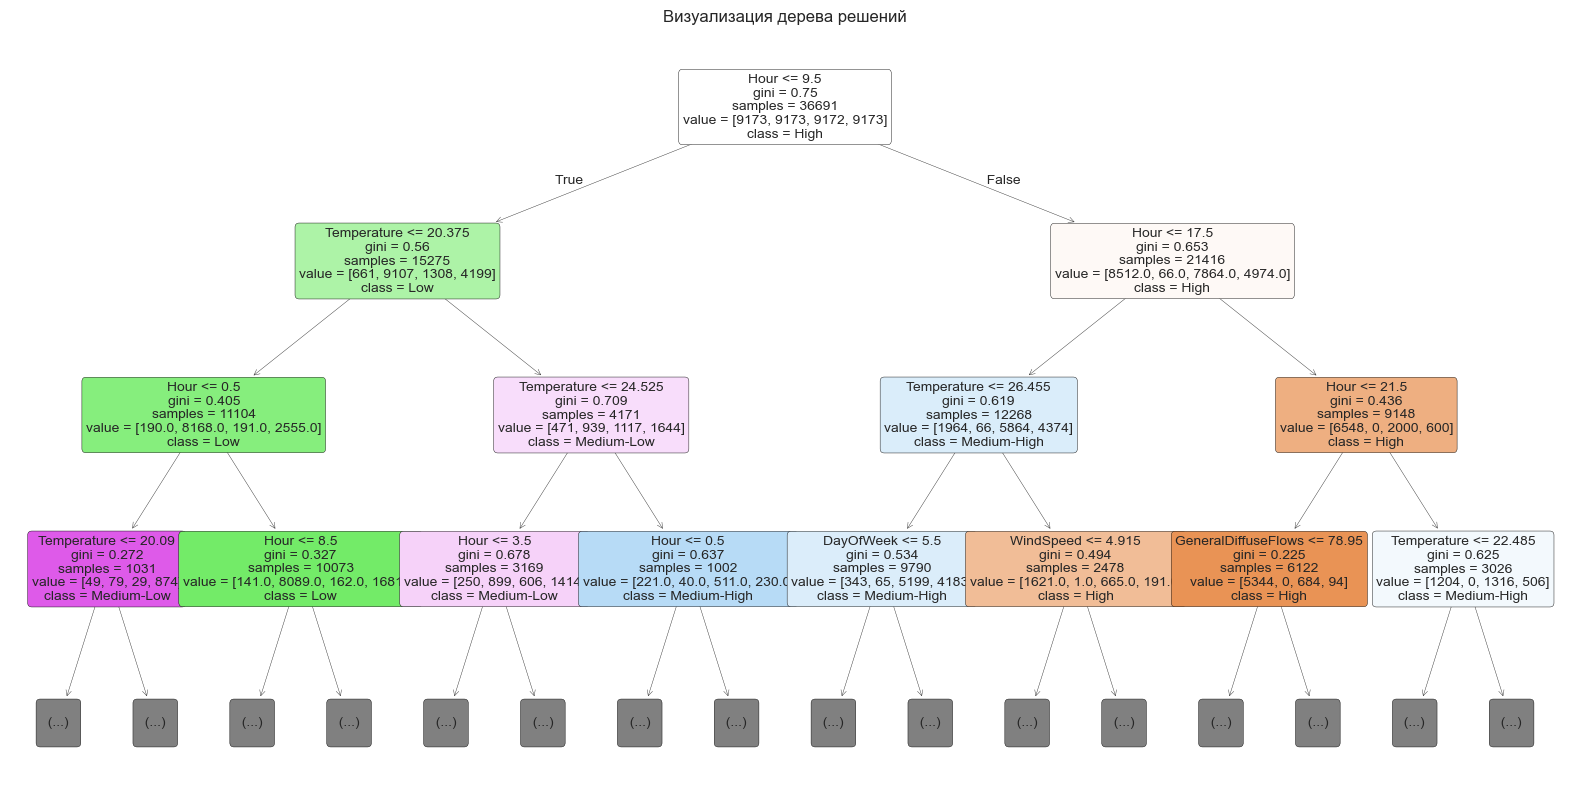

In [25]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=feature_columns, 
          class_names=le.classes_, rounded=True, max_depth=3, fontsize=10)
plt.title("Визуализация дерева решений")
plt.show()

# Определение лучшего алгоритма

In [26]:
best_algorithm = metrics_comparison.loc[metrics_comparison['Accuracy'].idxmax(), 'Algorithm']
best_accuracy = metrics_comparison.loc[metrics_comparison['Accuracy'].idxmax(), 'Accuracy']

print(f"Лучший алгоритм: {best_algorithm}")
print(f"Точность: {best_accuracy:.3f}")
print(f"Преимущество по точности: {abs(metrics_knn['Accuracy'] - metrics_dt['Accuracy']):.3f}")

Лучший алгоритм: kNN
Точность: 0.868
Преимущество по точности: 0.116


In [27]:
class_report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
class_report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

for class_name in le.classes_:
    idx = class_mapping[class_name]
    f1_knn = class_report_knn[str(idx)]['f1-score']
    f1_dt = class_report_dt[str(idx)]['f1-score']
    
    better_alg = "kNN" if f1_knn > f1_dt else "Decision Tree"
    diff = abs(f1_knn - f1_dt)
    print(f"   • {class_name}: {better_alg} (kNN: {f1_knn:.3f}, DT: {f1_dt:.3f}, разница: {diff:.3f})")

   • High: kNN (kNN: 0.919, DT: 0.848, разница: 0.071)
   • Low: kNN (kNN: 0.930, DT: 0.882, разница: 0.048)
   • Medium-High: kNN (kNN: 0.815, DT: 0.684, разница: 0.132)
   • Medium-Low: kNN (kNN: 0.808, DT: 0.574, разница: 0.233)


# Выводы:

kNN продемонстрировал выдающиеся результаты с точностью 86.85%, что на 11.64% превышает показатель дерева решений. Макро-усредненный AUC kNN составил 0.9736, что свидетельствует о практически идеальной разделяющей способности модели. В то же время дерево решений показало точность 75.21% с макро-AUC 0.9196, что является хорошим, но не выдающимся результатом.

Анализ классификации по отдельным классам выявил, что оба алгоритма успешно справляются с классификацией экстремальных уровней потребления High и Low, где разница в эффективности минимальна. Однако для промежуточных классов Medium-High и Medium-Low kNN демонстрирует значительное превосходство, особенно заметное для класса Medium-Low, где разница в F1-score достигает 23.3%.

Исследование важности признаков выявило абсолютное доминирование временных характеристик. Час дня оказался наиболее значимым признаком с весом 70.5%, что объясняется сильными суточными паттернами энергопотребления. Температура заняла второе место с весом 20.3%, отражая зависимость энергопотребления от климатических условий. День недели показал умеренную важность в 4.4%, в то время как остальные признаки оказались малозначимыми.

Полученные модели, особенно kNN с его высокой точностью, могут быть успешно применены в практических системах управления энергопотреблением. Они позволяют автоматически классифицировать уровни энергопотребления в реальном времени, оптимизировать распределение энергоресурсов, выявлять аномальные паттерны потребления и планировать профилактические работы на энергообъектах.